In [2]:
import pandas as pd
import sys, numpy as np
sys.path.append("/afs/cs.stanford.edu/u/anenberg/scr/caffe/python/")
import caffe
import lmdb


# location of the list that was used to create LMDB for training/testing
test_list = '../../data/allFrames/lists/fullpath_shuffle_sampled_100_test_list.txt'

N = 156800 # the number of test examples
num_classes = 101 # the number of classes

# Get the labels from the list

In [15]:
def get_label_from_list(list_filename):
    df = pd.read_csv(list_filename, delimiter= ' ', header = None, names = ['filename', 'class_id'])
    return df

df =  get_label_from_list(test_list)
labels = df.class_id.values
df['video_name'] = df.filename.apply(lambda x: x.split('/')[-2])

# Map the video to the labels

In [17]:
# map the videos to the labels
video_to_labels = list(set(zip(df.video_name, df.class_id)))
video_to_labels = pd.DataFrame(data=[l[1] for l in video_to_labels], index=[l[0] for l in video_to_labels], columns=['true_labels'])

In [12]:
video_to_labels = list(set(zip(df.video_name, df.class_id)))


In [33]:
len(video_to_labels)

1568

# Extract features using the extract_features binary

In [195]:
!./extract.sh 

E0306 18:16:05.343775 16268 extract_features.cpp:54] Using GPU
E0306 18:16:05.344267 16268 extract_features.cpp:60] Using Device_id=2
E0306 18:16:06.052824 16268 upgrade_proto.cpp:618] Attempting to upgrade input file specified using deprecated V1LayerParameter: ./quick_train_test.prototxt
E0306 18:16:09.663082 16268 extract_features.cpp:134] Extacting Features
E0306 18:16:19.302606 16268 extract_features.cpp:169] Extracted features of 1000 query images for feature blob fc8_allFrames
E0306 18:16:28.962952 16268 extract_features.cpp:169] Extracted features of 2000 query images for feature blob fc8_allFrames
E0306 18:16:38.564700 16268 extract_features.cpp:169] Extracted features of 3000 query images for feature blob fc8_allFrames
E0306 18:16:48.179500 16268 extract_features.cpp:169] Extracted features of 4000 query images for feature blob fc8_allFrames
E0306 18:16:57.882446 16268 extract_features.cpp:169] Extracted features of 5000 query images for feature blob fc8_allFrames
E0306 18:17

## Open and extract the data from the LMDB

In [5]:
env = lmdb.open('/afs/cs.stanford.edu/u/anenberg/scr/CS231N/examples/allFrames_finetune/extracted/features_100frames/', readonly=True)

predicted_labels = [] # for a particular image, this will be the argmax for the scores
data = np.zeros((N, num_classes)) # collect the scores for each image for each class

with env.begin() as txn:
    with txn.cursor() as cursor:
        for i in range(N):
            key = str(i)
            val = cursor.get(key)
            datum = caffe.proto.caffe_pb2.Datum()
            datum.ParseFromString(val)
            # datum.ListFields()[3][1] contains the scores
            data[i, :] = np.array(list(datum.ListFields()[3][1]))
            predicted_labels.append(np.argmax(np.array(list(datum.ListFields()[3][1]))))


In [46]:
data.shape

(156800, 101)

# create the normalized dataframe

In [47]:
normalized_data = np.exp(data)/sum(np.exp(data))
normalized_data = pd.DataFrame(normalized_data)

# average the probabilities across videos

In [48]:
normalized_data['video_name'] = df['video_name']
normalized_data = normalized_data.groupby('video_name').mean()
normalized_data['predicted_label'] = np.argmax(normalized_data.values, axis = 1)
normalized_data['true_label'] = video_to_labels

# Compute the average precision

In [43]:
def compute_average_precision(normalized_data, class_id):
    # given a class_id compute the average precision for that class
    df = normalized_data[[class_id, 'true_label', 'predicted_label']]
    df = df.sort(class_id, ascending=False)
    df['match'] = (df.true_label == class_id)
    df['precision'] = np.cumsum(df.match)/np.arange(1, len(normalized_data) + 1)
    df['recall'] = np.cumsum(df.match)/np.sum(df.true_label == class_id)
    df['delta_recall'] = np.diff(np.append([0], df.recall.values))
    df['rect_area'] = df['precision'] * df['delta_recall']
    return sum(df.rect_area)

average_precision = [] # list to hold average_precision

for class_id in range(num_classes):
    ca = compute_average_precision(normalized_data, class_id)
    average_precision.append(ca)

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


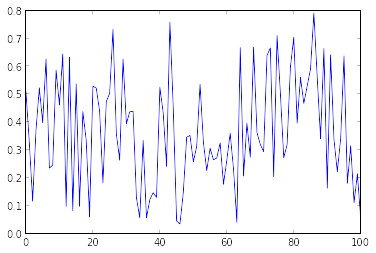

In [44]:
%pylab inline
plt.plot(average_precision)

/usr/local/lib/python2.7/dist-packages/numpy/core/fromnumeric.py:2499: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  VisibleDeprecationWarning)


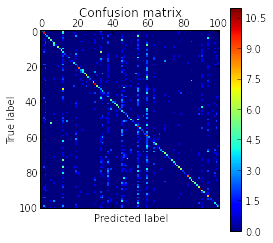

In [21]:
# Create confusion matrix
# Compute confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(normalized_data.true_label, normalized_data.predicted_label)

# Show confusion matrix in a separate window
plt.figure(figsize=(12, 12))
plt.matshow(cm)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


#Normalize scores to compute average precision for each class

In [45]:
print 'MAP: %2f'%np.mean(average_precision)

MAP: 0.370224


In [458]:
# What was the accuracy?
np.mean(normalized_data.true_label == normalized_data.predicted_label)

0.2110969387755102